In [1]:
!pip install transformers

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
import matplotlib.pyplot as plt
# import seaborn as sns


2024-03-10 06:59:08.488929: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
df = pd.read_csv('/LAB/blooms/augmented_data (1) - Copy.csv')
df.head()

,Questions,Blooms Taxonomy
0,Given is an array after the first partition of...,remember
1,How many steps are required to solve Tower of ...,remember
2,How many comparisons are required to find elem...,remember
3,"Given an array A[-3:4, 6:10], Find the address...",remember
4,"Consider the following list of 10 numbers: 35,...","apply , remember"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Questions        3511 non-null   object
 1   Blooms Taxonomy  3510 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


In [5]:
# Convert 'Understanding' to 'Understand' in 'Column_with_Understanding'
df['Blooms Taxonomy'] = df['Blooms Taxonomy'].replace('Understanding', 'understand')

print(df['Blooms Taxonomy'])

0               remember
1               remember
2               remember
3               remember
4       apply , remember
              ...       
3506               apply
3507            remember
3508               apply
3509            remember
3510            remember
Name: Blooms Taxonomy, Length: 3511, dtype: object


In [6]:
df.dropna(inplace=True)

In [7]:
word_to_encoding = {
    'remember': 0,
    'understand': 1,
    'apply': 2,
    'analyze': 3,
    'evaluate': 4,
    'create': 5
}

def map_words_to_encoding(words):
    words = [word.strip().lower() for word in words.split(',')]
    encoding_values = [word_to_encoding[word] for word in words if word in word_to_encoding]
    return max(encoding_values) if encoding_values else 0


df['encoded_values'] = df['Blooms Taxonomy'].apply(map_words_to_encoding)

print(df)

                                              Questions   Blooms Taxonomy  \
0     Given is an array after the first partition of...          remember   
1     How many steps are required to solve Tower of ...          remember   
2     How many comparisons are required to find elem...          remember   
3     Given an array A[-3:4, 6:10], Find the address...          remember   
4     Consider the following list of 10 numbers: 35,...  apply , remember   
...                                                 ...               ...   
3506  If RAM contains 4096 words and length of each ...             apply   
3507  Booth Multiplication Algorithm is used to calc...          remember   
3508  What can be length of control word for 8 regis...             apply   
3509  With respect to basic computer, before memory ...          remember   
3510  Protected mode provides several features like_...          remember   

      encoded_values  
0                  0  
1                  0  
2     

### **Data Preparation**

In [8]:
df['encoded_values'] = df['encoded_values'].astype(int)

In [9]:
df['encoded_values'].value_counts()

1    845
0    666
5    537
3    529
2    528
4    405
Name: encoded_values, dtype: int64

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [11]:
token = tokenizer.encode_plus(
    df['Questions'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

2024-03-10 06:59:11.948380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 06:59:13.055774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22346 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-03-10 06:59:13.057213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22346 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [12]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101, 10470,  1110,  1126,  9245,  1170,  1103,  1148, 16416,
         1104,  3613, 21484,  1204,   131,   124,   117,   121,   117,
          123,   117,   125,   117,  1275,   117,   129,   117,   128,
          117,   127,   117,   130,   119,  5979,  1104,  1103,  5290,
         1180,  1129,  1103,   185, 15435,  1204,   136,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [13]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [14]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Questions'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [15]:

X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [16]:

labels = np.zeros((len(df), 6))
labels.shape

(3510, 6)

In [17]:
labels[np.arange(len(df)), df['encoded_values'].values] = 1 # one-hot encoded target tensor

In [18]:
labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [19]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [20]:
def qualityDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [21]:
dataset = dataset.map(qualityDatasetMapFunction) # converting to required format for tensorflow dataset

In [22]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [23]:

p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [24]:

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

### **Model**

In [25]:
from transformers import TFBertModel

In [26]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [27]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

blooms_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
blooms_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [28]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')


In [29]:
from tensorflow.keras.metrics import Precision, Recall

In [30]:
blooms_model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy', Precision(), Recall()])

In [31]:
tf.__version__

'2.9.3'

In [32]:
hist = blooms_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100
)

Epoch 1/100


2024-03-10 06:59:35.569496: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


175/175 [==============================] - 50s 228ms/step - loss: 1.3612 - accuracy: 0.4657 - precision: 0.7806 - recall: 0.1779 - val_loss: 0.9583 - val_accuracy: 0.6520 - val_precision: 0.7793 - val_recall: 0.4815
Epoch 2/100
175/175 [==============================] - 39s 221ms/step - loss: 0.8824 - accuracy: 0.6689 - precision: 0.7710 - recall: 0.5482 - val_loss: 0.5909 - val_accuracy: 0.8026 - val_precision: 0.8712 - val_recall: 0.7401
Epoch 3/100
175/175 [==============================] - 39s 223ms/step - loss: 0.6576 - accuracy: 0.7693 - precision: 0.8309 - recall: 0.7021 - val_loss: 0.4838 - val_accuracy: 0.8438 - val_precision: 0.8756 - val_recall: 0.7997
Epoch 4/100
175/175 [==============================] - 39s 222ms/step - loss: 0.4920 - accuracy: 0.8286 - precision: 0.8637 - recall: 0.7900 - val_loss: 0.3878 - val_accuracy: 0.8679 - val_precision: 0.8927 - val_recall: 0.8509
Epoch 5/100
175/175 [==============================] - 39s 222ms/step - loss: 0.3764 - accuracy: 0.8

In [34]:
# from tensorflow.keras.utils import plot_model
# plot_model(blooms_model, to_file='blooms_model.png', show_shapes=True, show_layer_names=True)

In [40]:
blooms_model.save('/LAB/blooms/blooms_model.pkl')

INFO:tensorflow:Assets written to: /LAB/blooms/blooms_model.pkl/assets


INFO:tensorflow:Assets written to: /LAB/blooms/blooms_model.pkl/assets


In [36]:
blooms_model.evaluate(val_dataset)

44/44 [==============================] - 3s 68ms/step - loss: 0.0152 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901


[0.015197551809251308,
 0.9900568127632141,
 0.9900568127632141,
 0.9900568127632141]

### **Prediction**

In [41]:
blooms_model = tf.keras.models.load_model('/LAB/blooms/blooms_model.pkl')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['remember', 'understand', 'apply', 'analyze', 'evaluate','create']):
    probs = model.predict(processed_data)[0]
    # print(probs)
    return classes[np.argmax(probs)], one_hot_encode(probs, 6)

In [43]:
def one_hot_encode(arr, num_classes):
    # Find the index of the maximum value in the array
    max_index = np.argmax(arr)

    # Create a new array to hold the one-hot encoded values
    one_hot_encoded = np.zeros(num_classes)

    # Set the highest value to 1
    one_hot_encoded[max_index] = 1

    return one_hot_encoded.astype(int)

In [51]:
input_text = input('Enter Question here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(blooms_model, processed_data=processed_data)

print(f"Predicted blooms level: {result}")

Enter Question here: What is semaphore? For what purpose semaphore can be used? Give a deadlock free solution to solve Dining Philosophers problem using semaphores.
1/1 [==============================] - 0s 73ms/step
Predicted blooms level: ('apply', array([0, 0, 1, 0, 0, 0]))


In [52]:
input_text = input('Enter Question here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(blooms_model, processed_data=processed_data)

print(f"Predicted blooms level: {result}")

Enter Question here: What is meant by RAID? Explain various levels of RAID with its major functionality.
1/1 [==============================] - 0s 72ms/step
Predicted blooms level: ('understand', array([0, 1, 0, 0, 0, 0]))


In [53]:
no_of_questions = int(input('Enter the number of questions: '))

for i in range(no_of_questions):
    input_text = input(f'Enter Question {i + 1}: ')
    processed_data = prepare_data(input_text, tokenizer)
    result = make_prediction(blooms_model, processed_data=processed_data)
    print(f"Question {i + 1}: Predicted blooms level: {result}")


Enter the number of questions: 2
Enter Question 1: What is system protection in an operating system? How does the OS achieve it using an access matrix?
1/1 [==============================] - 0s 70ms/step
Question 1: Predicted blooms level: ('understand', array([0, 1, 0, 0, 0, 0]))
Enter Question 2: Define Buffer cache. Explain the buffer header with a suitable diagram.
1/1 [==============================] - 0s 74ms/step
Question 2: Predicted blooms level: ('apply', array([0, 0, 1, 0, 0, 0]))


In [46]:
new_input_ids = []
new_attention_mask = []
new_labels = []
for i, j in val_dataset:

  for q in i["input_ids"]:
    new_input_ids.append(q.numpy().astype(int))

  for a_m in i["attention_mask"]:
    new_attention_mask.append(a_m.numpy().astype(int))

  for k in j:
    new_labels.append(k.numpy())

print(len(new_input_ids), len(new_attention_mask), len(new_labels))

704 704 704


In [47]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, top_k_accuracy_score, confusion_matrix
import numpy as np

# Assuming you already have the trained model and validation data generator (val_generator) from the previous code

# Evaluate the model on the validation set
predictions = []

for i in range(len(new_labels)):
  predictions.append(make_prediction(blooms_model, {'input_ids': new_input_ids[i].reshape(1, -1), 'attention_mask': new_attention_mask[i].reshape(1, -1)})[1])

# Convert predictions to class labels
# predicted_labels = np.argmax(predictions)

# Convert true labels to class labels
# true_labels = val_dataset.classes

predicted_labels = []
true_labels = []
for i in range(len(new_labels)):
  predicted_labels.append(np.argmax(predictions[i]))
  true_labels.append(np.argmax(new_labels[i]))

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate recall, F1 score, and classification report
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels)

# Print the metrics
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

1/1 [==============================] - 0s 60ms/step
Overall Accuracy: 98.86%
Recall: 98.86%
F1 Score: 98.86%
[[136   3   0   0   0   1]
 [  0 168   0   0   0   0]
 [  0   0 110   0   0   2]
 [  1   0   0  96   0   0]
 [  1   0   0   0  77   0]
 [  0   0   0   0   0 109]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       140
           1       0.98      1.00      0.99       168
           2       1.00      0.98      0.99       112
           3       1.00      0.99      0.99        97
           4       1.00      0.99      0.99        78
           5       0.97      1.00      0.99       109

    accuracy                           0.99       704
   macro avg       0.99      0.99      0.99       704
weighted avg       0.99      0.99      0.99       704



In [49]:
!pip install seaborn

     |████████████████████████████████| 294 kB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


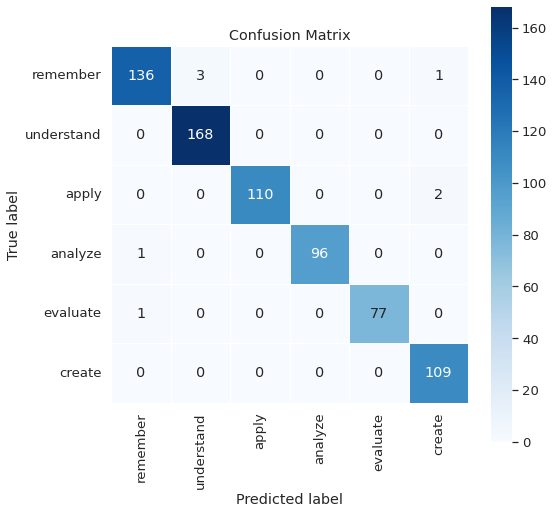

In [50]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix for multi-class classification.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        classes (list): List of class names.
        title (str): Title of the plot.
        cmap (matplotlib.colors.Colormap): Colormap for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(len(classes)+2, len(classes)+2))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, linewidths=.5, square=True,
                xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels

plot_confusion_matrix(true_labels, predicted_labels, classes=['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create'])
